# BERT on Samples
Create 10 BERT model, each one trained on a sample of twitter-whisperer dataset.

Then test each model 2 datasets:
1. agreement of at least 2 annotators;
2. agreement of 3 annotators.


## Set the variables

In [1]:
"""
# directories
main_path = "/content/drive/MyDrive/Colab Notebooks/"
data_path = main_path+"data/"
results_path = main_path+"results/"
models_path = main_path+"models/"
dataset_our_filename = "annotation_results__ann"
dataset_wt_filename = "sample_ann2_"

# classes
Y_feat_names = ["ns", "sens"]
"""

# directories
main_path = "/content/drive/MyDrive/Colab Notebooks/" # "./"
data_path = main_path+"data/"
results_path = main_path+"results/"
dataset_our_filename = "annotation_results.csv"
dataset_sample_filename = "sample_ann2_"
models_path = results_path+"models/"

# classes
Y_feat_names = ["ns", "sens"]


## Import libraries

In [ ]:
# install ktrain on Google Colab
!pip3 install ktrain

## for explaination
#!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [3]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# import modules in local directory
import sys
sys.path.append(main_path+'/lib')

Mounted at /content/drive


In [4]:
# import ktrain and the ktrain.text modules
import ktrain
from ktrain import text

import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#from utils import get_data, get_two_classes, my_train_val_test_split, plot_confusion_matrix_from_cmat, predict_class_BERT
from utils import get_data, get_two_classes, plot_confusion_matrix_from_cmat, predict_class_BERT

from sklearn import metrics

In [5]:
def get_metrics(y_test, y_pred, Y_feat_names):
    res = {}
    res["accuracy"] = metrics.accuracy_score(y_test, y_pred)
    tmp = metrics.precision_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["precision_"+cls] = tmp[index]
    tmp = metrics.recall_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["recall_"+cls] = tmp[index]
    tmp = metrics.f1_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["f1_"+cls] = tmp[index]
    res["f1-micro"] = metrics.f1_score(y_test, y_pred, average="micro")
    res["f1-macro"] = metrics.f1_score(y_test, y_pred, average="macro")
    return res

def predict_class_BERT_2(text, predictor, Y_feat_names, real_class=None):
    result_pred = predictor.predict_proba(text)
    result_feat = Y_feat_names[0]
    if result_pred[1] > result_pred[0]:
        result_feat = Y_feat_names[1]
    return result_feat

def test_BERT(x_test, y_test_feat, predictor, data_name, set_name, Y_feat_names):
    y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test]
    met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
    met_dict_loc["data"] = data_name
    met_dict_loc["set"] = set_name
    return met_dict_loc

def test_only_pipeline(sample_filename_prefix, sample_index, additional_tests, predictor, Y_feat_names):
    str_index = ("0"+str(sample_index))[-2:]
    # get data
    test_loc = pd.read_csv(sample_filename_prefix+str_index+"_test.csv")
    x_test = test_loc["text"].tolist()
    #y_test = pd.get_dummies(pd.DataFrame({"class": test_loc["class"].tolist()})["class"])[Y_feat_names].values
    y_test_feat = test_loc["class"].tolist()
    # validation on test set - complete
    met_dict = []
    print(" - testing local set")
    #y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test]
    met_dict_loc = test_BERT(x_test, y_test_feat, predictor, "sample"+str_index, "test", Y_feat_names)
    met_dict.append(met_dict_loc)
    # validation on other test sets - complete
    for add_test in additional_tests:
        print(" - testing", add_test["name"])
        met_dict_loc = test_BERT(add_test["text"], add_test["class"], predictor, "sample"+str_index, add_test["name"], Y_feat_names)
        met_dict.append(met_dict_loc)
    return pd.DataFrame(met_dict)

def training_pipeline(sample_filename_prefix, sample_index, additional_tests, models_path, Y_feat_names):
    str_index = ("0"+str(sample_index))[-2:]
    # get data
    train_loc = pd.read_csv(sample_filename_prefix+str_index+"_training.csv")
    val_loc = pd.read_csv(sample_filename_prefix+str_index+"_validation.csv")
    test_loc = pd.read_csv(sample_filename_prefix+str_index+"_test.csv")
    # transform data into sets for models
    x_train = train_loc["text"].tolist()
    y_train = pd.get_dummies(pd.DataFrame({"class": train_loc["class"].tolist()})["class"])[Y_feat_names].values
    x_val = val_loc["text"].tolist()
    y_val = pd.get_dummies(pd.DataFrame({"class": val_loc["class"].tolist()})["class"])[Y_feat_names].values
    x_test = test_loc["text"].tolist()
    y_test = pd.get_dummies(pd.DataFrame({"class": test_loc["class"].tolist()})["class"])[Y_feat_names].values
    # load and preprocess data
    (x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                          x_test=x_val, y_test=y_val,
                                                                                          class_names=Y_feat_names,
                                                                                          preprocess_mode='bert',
                                                                                          lang='en',
                                                                                          maxlen=350, 
                                                                                          max_features=35000)
    # load the BERT Model and Instantiate a Learner object
    model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
    learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=6)
    # train the model
    learner.autofit(5e-5)
    learner.plot()
    # save the trained model
    predictor = ktrain.get_predictor(learner.model, preproc)
    predictor.save(models_path+"sensitag_BERT_sample"+str_index)
    # validation on validation set
    df_val = learner.evaluate()
    plot_confusion_matrix_from_cmat(df_val, normalize=True, labels=Y_feat_names)
    # validation on test set
    x_test_bert = preproc.preprocess(x_test)
    df_test = learner.validate(val_data=(x_test_bert, y_test), class_names=Y_feat_names)
    plot_confusion_matrix_from_cmat(df_test, normalize=True, labels=Y_feat_names)
    # validation on test set - complete
    met_dict = []
    print(" - testing local set")
    y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test]
    met_dict_loc = test_BERT(x_test, y_test_feat, predictor, "sample"+str_index, "test", Y_feat_names)
    """
    y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test]
    met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
    met_dict_loc["set"] = "test"
    met_dict_loc["data"] = "sample"+str_index
    """
    met_dict.append(met_dict_loc)
    # validation on other test sets - complete
    for add_test in additional_tests:
        print(" - testing", add_test["name"])
        met_dict_loc = test_BERT(add_test["text"], add_test["class"], predictor, "sample"+str_index, add_test["name"], Y_feat_names)
        """
        #test_loc = pd.read_csv(data_path+dataset_wt_filename+(("0"+str(index+1))[-2:])+".csv")
        #x_test_loc = test_loc["text"].tolist()
        #y_test_feat = test_loc["class"].tolist()
        x_test_loc = add_test["text"]
        y_test_feat = add_test["class"]
        y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
        met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
        met_dict_loc["set"] = add_test["name"]
        met_dict_loc["data"] = "sample"+str_index
        """
        met_dict.append(met_dict_loc)
    return pd.DataFrame(met_dict)


In [6]:
additional_tests = []
for ann in [2,3]:
    data_loc = get_data(data_path+dataset_our_filename, lim=ann)
    data_loc = get_two_classes(data_loc)
    dict_loc = {"name": "ann"+str(ann), "text": data_loc["text"].tolist(), "class": data_loc["class"].tolist()}
    additional_tests.append(dict_loc)


downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 1429s 1s/step - loss: 0.4625 - accuracy: 0.7741 - val_loss: 0.2585 - val_accuracy: 0.8980
Epoch 2/1024
1096/1096 [==============================] - 1412s 1s/step - loss: 0.1886 - accuracy: 0.9293 - val_loss: 0.2636 - val_accuracy: 0.8965
Epoch 3/1024
1096/1096 [==============================] - 1416s 1s/step - loss: 0.0816 - accuracy: 0.9737 - val_loss: 0.3479 - val_accuracy: 0.8896

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 1418s 1s/step - loss: 0.0301 - accuracy: 0.9919 - val_loss: 0.4444 - val_accuracy: 0.8965
Epoch 5/1024
1096/1096 [==============================] - 1419

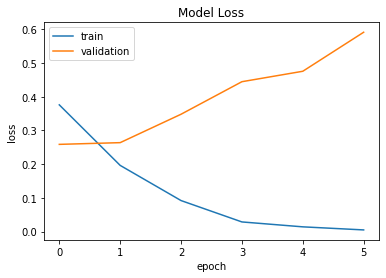

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       814
           1       0.87      0.87      0.87       500

    accuracy                           0.90      1314
   macro avg       0.89      0.89      0.89      1314
weighted avg       0.90      0.90      0.90      1314



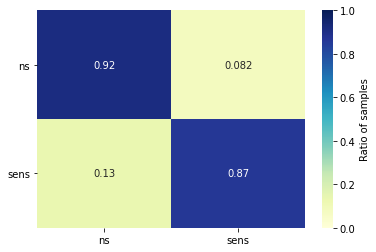

              precision    recall  f1-score   support

          ns       0.90      0.92      0.91       543
        sens       0.87      0.83      0.85       333

    accuracy                           0.89       876
   macro avg       0.88      0.88      0.88       876
weighted avg       0.89      0.89      0.89       876



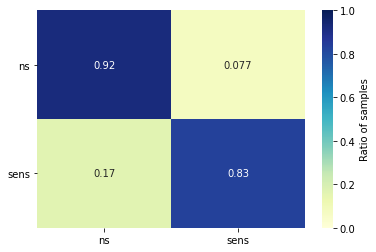

 - testing local set
 - testing ann2
 - testing ann3


In [ ]:
df_met = training_pipeline(data_path+dataset_sample_filename, 1, additional_tests, models_path, Y_feat_names)


In [ ]:
#df_met.to_csv((results_path+"01 - Sensitag-BERT - sample/ann3.csv")
# reload the predictor
#predictor = ktrain.load_predictor(models_path+"sensitag_BERT_sample01")
# test
df_met = test_only_pipeline(data_path+dataset_sample_filename, 1, additional_tests, predictor, Y_feat_names)
df_met

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.889269,0.901079,0.868750,0.922652,0.834835,0.911738,0.851455,0.889269,0.881596,sample01,test
1,0.559726,0.607770,0.323430,0.815436,0.143585,0.696452,0.198879,0.559726,0.447666,sample01,ann2
2,0.554128,0.619533,0.245763,0.794773,0.120499,0.696296,0.161710,0.554128,0.429003,sample01,ann3


In [ ]:
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_01.csv")


downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 847s 758ms/step - loss: 0.4318 - accuracy: 0.7967 - val_loss: 0.2645 - val_accuracy: 0.8828
Epoch 2/1024
1096/1096 [==============================] - 828s 756ms/step - loss: 0.1881 - accuracy: 0.9271 - val_loss: 0.2986 - val_accuracy: 0.8820
Epoch 3/1024
1096/1096 [==============================] - 828s 755ms/step - loss: 0.0914 - accuracy: 0.9709 - val_loss: 0.3309 - val_accuracy: 0.8767

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 828s 756ms/step - loss: 0.0371 - accuracy: 0.9897 - val_loss: 0.4111 - val_accuracy: 0.8896
Epoch 5/1024
1096/1096 [==============================

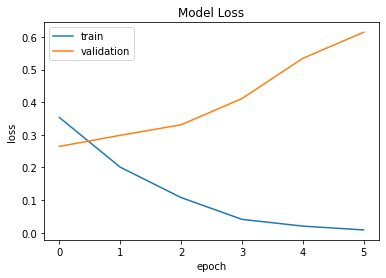

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       814
           1       0.86      0.83      0.84       500

    accuracy                           0.88      1314
   macro avg       0.88      0.87      0.87      1314
weighted avg       0.88      0.88      0.88      1314



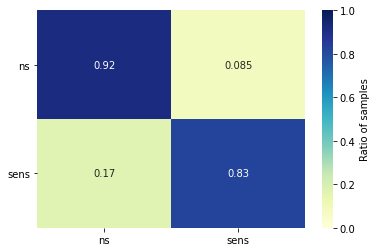

              precision    recall  f1-score   support

          ns       0.89      0.92      0.91       543
        sens       0.87      0.82      0.84       333

    accuracy                           0.88       876
   macro avg       0.88      0.87      0.87       876
weighted avg       0.88      0.88      0.88       876



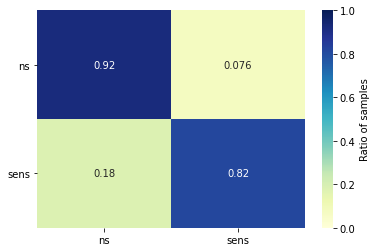

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.883562,0.891652,0.869010,0.924494,0.816817,0.907776,0.842105,0.883562,0.874941,sample02,test
1,0.587222,0.616824,0.360947,0.880641,0.109712,0.725493,0.168276,0.587222,0.446885,sample02,ann2
2,0.589965,0.632184,0.275574,0.866641,0.091413,0.731075,0.137285,0.589965,0.434180,sample02,ann3


In [ ]:
df_met = training_pipeline(data_path+dataset_sample_filename, 2, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_02.csv")
df_met


preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 831s 743ms/step - loss: 0.4243 - accuracy: 0.8104 - val_loss: 0.3270 - val_accuracy: 0.8676
Epoch 2/1024
1096/1096 [==============================] - 828s 756ms/step - loss: 0.1813 - accuracy: 0.9364 - val_loss: 0.3509 - val_accuracy: 0.8752
Epoch 3/1024
1096/1096 [==============================] - 830s 757ms/step - loss: 0.0809 - accuracy: 0.9727 - val_loss: 0.4447 - val_accuracy: 0.8645

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 829s 757ms/step - loss: 0.0287 - accuracy: 0.9904 - val_loss: 0.6546 - val_accuracy: 0.8607
Epoch 5/1024
1096/1096 [==============================

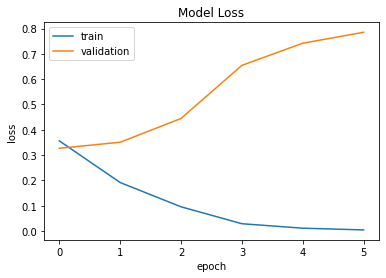

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       814
           1       0.86      0.77      0.82       500

    accuracy                           0.87      1314
   macro avg       0.87      0.85      0.86      1314
weighted avg       0.87      0.87      0.87      1314



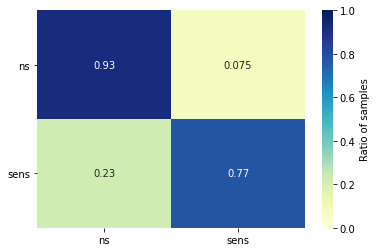

              precision    recall  f1-score   support

          ns       0.88      0.92      0.90       543
        sens       0.86      0.80      0.83       333

    accuracy                           0.88       876
   macro avg       0.87      0.86      0.87       876
weighted avg       0.88      0.88      0.87       876



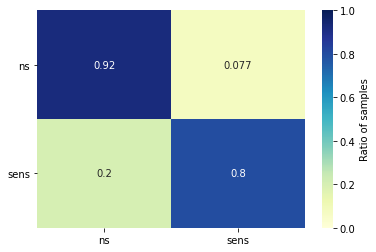

 - testing local set
 - testing ann2
 - testing ann3


In [ ]:
df_met = training_pipeline(data_path+dataset_sample_filename, 3, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_03.csv")

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 831s 743ms/step - loss: 0.4544 - accuracy: 0.7944 - val_loss: 0.2776 - val_accuracy: 0.8866
Epoch 2/1024
1096/1096 [==============================] - 824s 752ms/step - loss: 0.1873 - accuracy: 0.9275 - val_loss: 0.2882 - val_accuracy: 0.8912
Epoch 3/1024
1096/1096 [==============================] - 823s 751ms/step - loss: 0.0939 - accuracy: 0.9681 - val_loss: 0.3469 - val_accuracy: 0.8760

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 823s 751ms/step - loss: 0.0295 - accuracy: 0.9911 - val_loss: 0.3984 - val_accuracy: 0.8919
Epoch 5/1024
1096/1096 [==============================

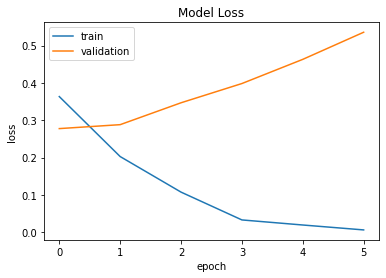

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       814
           1       0.86      0.84      0.85       500

    accuracy                           0.89      1314
   macro avg       0.88      0.88      0.88      1314
weighted avg       0.89      0.89      0.89      1314



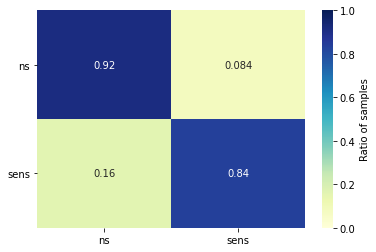

              precision    recall  f1-score   support

          ns       0.89      0.94      0.91       543
        sens       0.88      0.80      0.84       333

    accuracy                           0.88       876
   macro avg       0.88      0.87      0.88       876
weighted avg       0.88      0.88      0.88       876



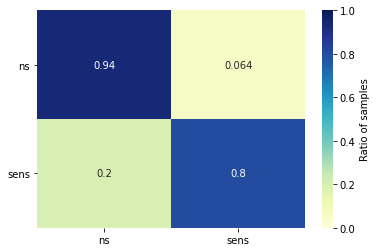

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.884703,0.885017,0.884106,0.935543,0.801802,0.909579,0.840945,0.884703,0.875262,sample04,test
1,0.569196,0.608082,0.303220,0.856511,0.101619,0.711227,0.152223,0.569196,0.431725,sample04,ann2
2,0.573159,0.625107,0.242259,0.840123,0.092105,0.716839,0.133467,0.573159,0.425153,sample04,ann3


In [ ]:
df_met = training_pipeline(data_path+dataset_sample_filename, 4, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_04.csv")
df_met

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 837s 748ms/step - loss: 0.4676 - accuracy: 0.7718 - val_loss: 0.2966 - val_accuracy: 0.8668
Epoch 2/1024
1096/1096 [==============================] - 831s 758ms/step - loss: 0.1822 - accuracy: 0.9345 - val_loss: 0.3017 - val_accuracy: 0.8805
Epoch 3/1024
1096/1096 [==============================] - 830s 757ms/step - loss: 0.1083 - accuracy: 0.9654 - val_loss: 0.3766 - val_accuracy: 0.8668

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 830s 758ms/step - loss: 0.0396 - accuracy: 0.9901 - val_loss: 0.4683 - val_accuracy: 0.8721
Epoch 5/1024
1096/1096 [==============================

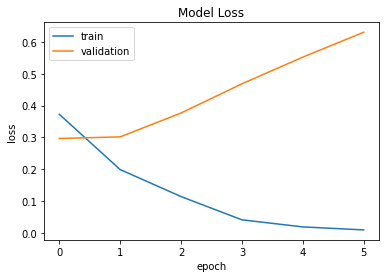

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       814
           1       0.82      0.84      0.83       500

    accuracy                           0.87      1314
   macro avg       0.86      0.86      0.86      1314
weighted avg       0.87      0.87      0.87      1314



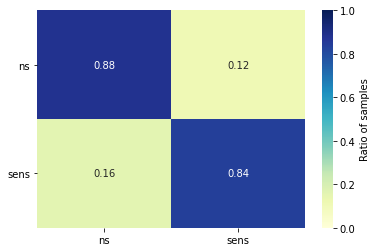

              precision    recall  f1-score   support

          ns       0.90      0.92      0.91       543
        sens       0.86      0.83      0.84       333

    accuracy                           0.88       876
   macro avg       0.88      0.87      0.87       876
weighted avg       0.88      0.88      0.88       876



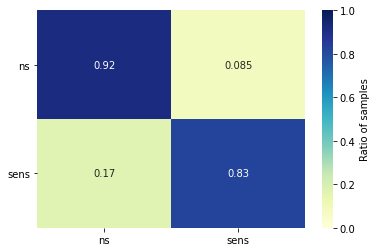

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.882420,0.897112,0.857143,0.915285,0.828829,0.906108,0.842748,0.882420,0.874428,sample05,test
1,0.575471,0.613958,0.348544,0.847486,0.132794,0.712064,0.192316,0.575471,0.452190,sample05,ann2
2,0.575383,0.629013,0.279032,0.828209,0.119806,0.714997,0.167636,0.575383,0.441316,sample05,ann3


In [ ]:
df_met = training_pipeline(data_path+dataset_sample_filename, 5, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_05.csv")
df_met

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 863s 772ms/step - loss: 0.4413 - accuracy: 0.7932 - val_loss: 0.2884 - val_accuracy: 0.8805
Epoch 2/1024
1096/1096 [==============================] - 852s 777ms/step - loss: 0.1946 - accuracy: 0.9308 - val_loss: 0.3061 - val_accuracy: 0.8843
Epoch 3/1024
1096/1096 [==============================] - 850s 776ms/step - loss: 0.1064 - accuracy: 0.9624 - val_loss: 0.3714 - val_accuracy: 0.8820

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 851s 777ms/step - loss: 0.0445 - accuracy: 0.9853 - val_loss: 0.4716 - val_accuracy: 0.8767
Epoch 5/1024
1096/1096 [==============================

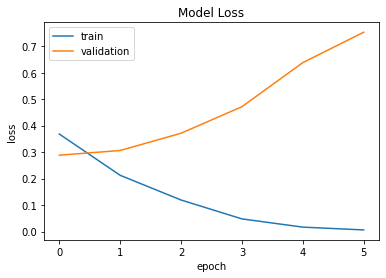

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       814
           1       0.85      0.83      0.84       500

    accuracy                           0.88      1314
   macro avg       0.87      0.87      0.87      1314
weighted avg       0.88      0.88      0.88      1314



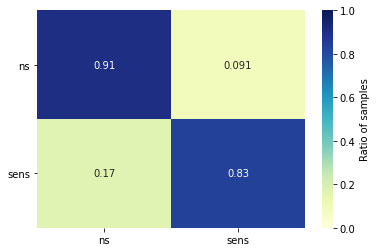

              precision    recall  f1-score   support

          ns       0.91      0.92      0.91       543
        sens       0.86      0.84      0.85       333

    accuracy                           0.89       876
   macro avg       0.88      0.88      0.88       876
weighted avg       0.89      0.89      0.89       876



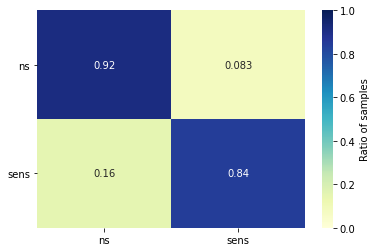

 - testing local set
 - testing ann2
 - testing ann3


TypeError: ignored

In [ ]:
sample_index = 6
df_met = training_pipeline(data_path+dataset_sample_filename, sample_index, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_0"+(("0"+str(sample_index))[-2:])+".csv")
df_met

In [ ]:
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_0"+(("0"+str(sample_index))[-2:])+".csv")
df_met

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.889269,0.905455,0.861963,0.917127,0.843844,0.911253,0.852807,0.889269,0.882030,sample06,test
1,0.582886,0.616937,0.364865,0.861485,0.129496,0.718985,0.191150,0.582886,0.455068,sample06,ann2
2,0.589471,0.634390,0.300917,0.853574,0.113573,0.727839,0.164907,0.589471,0.446373,sample06,ann3


downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 795s 707ms/step - loss: 0.4341 - accuracy: 0.7986 - val_loss: 0.3081 - val_accuracy: 0.8607
Epoch 2/1024
1096/1096 [==============================] - 787s 718ms/step - loss: 0.1957 - accuracy: 0.9290 - val_loss: 0.3514 - val_accuracy: 0.8592
Epoch 3/1024
1096/1096 [==============================] - 787s 718ms/step - loss: 0.1068 - accuracy: 0.9673 - val_loss: 0.3914 - val_accuracy: 0.8592

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 786s 717ms/step - loss: 0.0323 - accuracy: 0.9918 - val_loss: 0.5218 - val_accuracy: 0.8630
Epoch 5/1024
1096/1096 [==============================

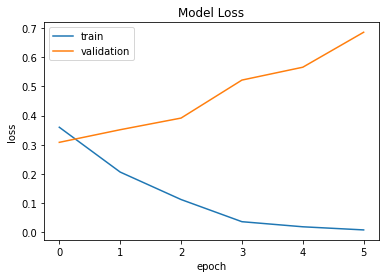

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       814
           1       0.81      0.83      0.82       500

    accuracy                           0.86      1314
   macro avg       0.85      0.86      0.85      1314
weighted avg       0.86      0.86      0.86      1314



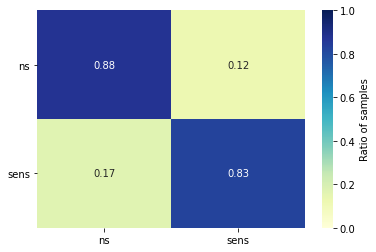

              precision    recall  f1-score   support

          ns       0.90      0.92      0.91       543
        sens       0.86      0.83      0.85       333

    accuracy                           0.89       876
   macro avg       0.88      0.88      0.88       876
weighted avg       0.89      0.89      0.89       876



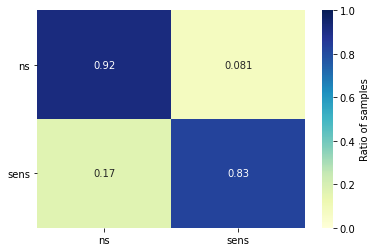

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.885845,0.899099,0.862928,0.918969,0.831832,0.908925,0.847095,0.885845,0.878010,sample07,test
1,0.581289,0.615556,0.355286,0.862958,0.122902,0.718558,0.182628,0.581289,0.450593,sample07,ann2
2,0.588977,0.633570,0.293785,0.855880,0.108033,0.728135,0.157975,0.588977,0.443055,sample07,ann3


In [ ]:
sample_index = 7
df_met = training_pipeline(data_path+dataset_sample_filename, sample_index, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_0"+(("0"+str(sample_index))[-2:])+".csv")
df_met

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 818s 727ms/step - loss: 0.4270 - accuracy: 0.7998 - val_loss: 0.2761 - val_accuracy: 0.8919
Epoch 2/1024
1096/1096 [==============================] - 793s 724ms/step - loss: 0.1828 - accuracy: 0.9350 - val_loss: 0.3046 - val_accuracy: 0.8874
Epoch 3/1024
1096/1096 [==============================] - 795s 725ms/step - loss: 0.1030 - accuracy: 0.9651 - val_loss: 0.3552 - val_accuracy: 0.8881

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 795s 725ms/step - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.4460 - val_accuracy: 0.8828
Epoch 5/1024
1096/1096 [==============================

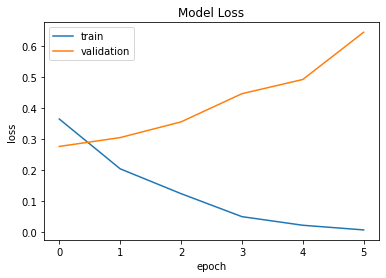

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       814
           1       0.89      0.82      0.85       500

    accuracy                           0.89      1314
   macro avg       0.89      0.88      0.88      1314
weighted avg       0.89      0.89      0.89      1314



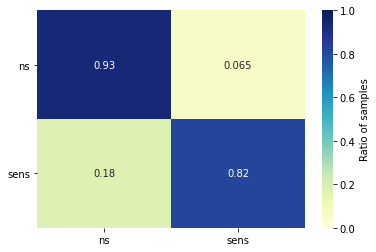

              precision    recall  f1-score   support

          ns       0.90      0.95      0.92       543
        sens       0.91      0.82      0.87       333

    accuracy                           0.90       876
   macro avg       0.91      0.89      0.89       876
weighted avg       0.90      0.90      0.90       876



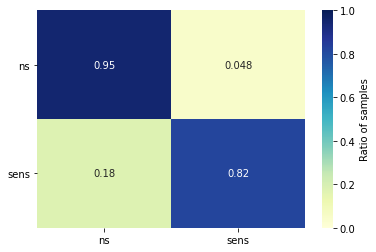

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.902968,0.897569,0.913333,0.952118,0.822823,0.924039,0.865719,0.902968,0.894879,sample08,test
1,0.587108,0.614673,0.337915,0.893535,0.088429,0.728324,0.140176,0.587108,0.434250,sample08,ann2
2,0.588235,0.628997,0.234450,0.877018,0.067867,0.732584,0.105263,0.588235,0.418924,sample08,ann3


In [7]:
sample_index = 8
df_met = training_pipeline(data_path+dataset_sample_filename, sample_index, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_0"+(("0"+str(sample_index))[-2:])+".csv")
df_met

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 814s 727ms/step - loss: 0.4466 - accuracy: 0.7968 - val_loss: 0.3086 - val_accuracy: 0.8775
Epoch 2/1024
1096/1096 [==============================] - 795s 726ms/step - loss: 0.1832 - accuracy: 0.9327 - val_loss: 0.3319 - val_accuracy: 0.8752
Epoch 3/1024
1096/1096 [==============================] - 795s 726ms/step - loss: 0.0841 - accuracy: 0.9703 - val_loss: 0.4265 - val_accuracy: 0.8706

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 795s 725ms/step - loss: 0.0295 - accuracy: 0.9924 - val_loss: 0.5226 - val_accuracy: 0.8737
Epoch 5/1024
1096/1096 [==============================

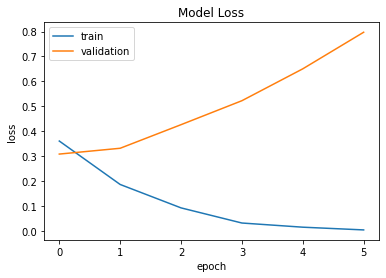

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       814
           1       0.86      0.81      0.83       500

    accuracy                           0.88      1314
   macro avg       0.87      0.86      0.87      1314
weighted avg       0.88      0.88      0.88      1314



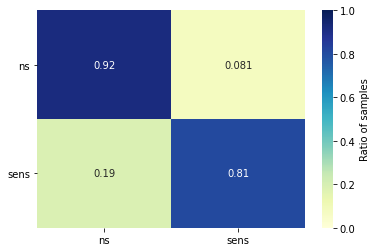

              precision    recall  f1-score   support

          ns       0.91      0.92      0.91       543
        sens       0.87      0.84      0.86       333

    accuracy                           0.89       876
   macro avg       0.89      0.88      0.88       876
weighted avg       0.89      0.89      0.89       876



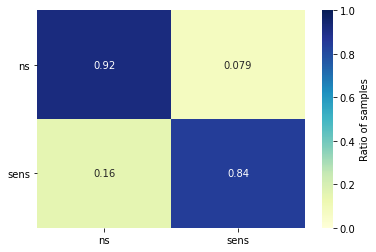

 - testing local set
 - testing ann2
 - testing ann3


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,data,set
0,0.891553,0.905797,0.867284,0.920810,0.843844,0.913242,0.855403,0.891553,0.884323,sample09,test
1,0.576954,0.613090,0.339100,0.859274,0.117506,0.715601,0.174533,0.576954,0.445067,sample09,ann2
2,0.576866,0.626853,0.250929,0.845119,0.093490,0.719804,0.136226,0.576866,0.428015,sample09,ann3


In [8]:
sample_index = 9
df_met = training_pipeline(data_path+dataset_sample_filename, sample_index, additional_tests, models_path, Y_feat_names)
df_met.to_csv(results_path+"01 - Sensitag-BERT - sample/sample_0"+(("0"+str(sample_index))[-2:])+".csv")
df_met